In [18]:
# resnet-9 model

import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pathlib

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "MRO" / "PurgeFan" / "resnet_dataset"
print(DATASET_PATH)

# train dataset preparation
classes = ['normal', 'fault']
dataset = ImageFolder(DATASET_PATH, transform=tt.ToTensor())
dataloader = DataLoader(dataset, batch_size=25)

for data, _ in dataloader:
    print(data.size())
    break

/Users/byunghunhwang/dev/flame-autonomous/dataset/MRO/PurgeFan/resnet_dataset
torch.Size([25, 3, 224, 224])


In [20]:
# calculation for mean and std of images for normalization
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    print(channels_sum, channels_squared_sum, num_batches)
    
    return mean, std

mean, std = get_mean_and_std(dataloader)
print(mean)
print(std)

tensor([  6.3116,  39.7513, 271.6382]) tensor([  3.3959,  22.4454, 237.9630]) 320
tensor([0.0197, 0.1242, 0.8489])
tensor([0.1011, 0.2339, 0.1518])


In [30]:
# trainset, validationset images are transforming to tensors and the images are normalized
stats = (tuple(mean.tolist()), tuple(std.tolist()))
train_transform = tt.Compose([tt.ToTensor(), tt.Normalize(*stats, inplace=True)])
valid_transform = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [31]:
# performing all transformation on the dataset
train_dataset = ImageFolder((DATASET_PATH/"train").as_posix(), train_transform)
valid_dataset = ImageFolder((DATASET_PATH/"test").as_posix(), valid_transform)

In [47]:
# create data loader
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=25, num_workers=4, pin_memory=True)

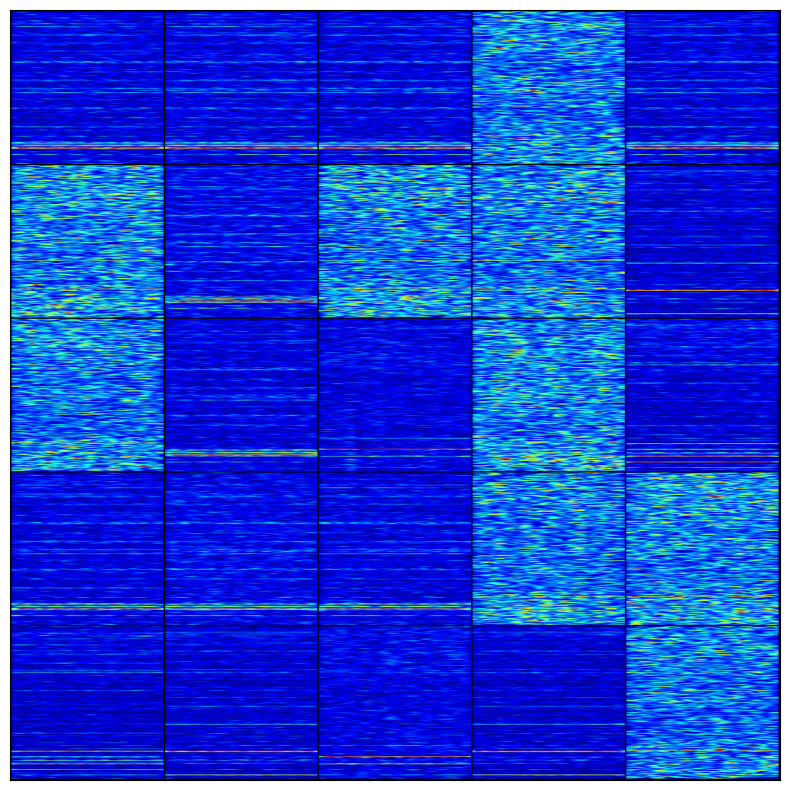

In [48]:
# plot
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=5).permute(1, 2, 0).clamp(0,1))
        break
    
show_batch(train_dataloader)

In [58]:
# device
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device) -> None:
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dataloader)
    
device = get_default_device()
print(device)

mps


In [59]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
valid_dataloader = DeviceDataLoader(valid_dataloader, device)

In [60]:
# defining functions for calculating accuracy and loss
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))
        
# design residual model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [61]:
model = ResNet9(3, 2)

In [62]:
from torchinfo import summary

summary(model, input_size=(25, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [25, 2]                   --
├─Sequential: 1-1                        [25, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [25, 64, 32, 32]          1,792
│    └─BatchNorm2d: 2-2                  [25, 64, 32, 32]          128
│    └─ReLU: 2-3                         [25, 64, 32, 32]          --
├─Sequential: 1-2                        [25, 128, 16, 16]         --
│    └─Conv2d: 2-4                       [25, 128, 32, 32]         73,856
│    └─BatchNorm2d: 2-5                  [25, 128, 32, 32]         256
│    └─ReLU: 2-6                         [25, 128, 32, 32]         --
│    └─MaxPool2d: 2-7                    [25, 128, 16, 16]         --
├─Sequential: 1-3                        [25, 128, 16, 16]         --
│    └─Sequential: 2-8                   [25, 128, 16, 16]         --
│    │    └─Conv2d: 3-1                  [25, 128, 16, 16]         147,584
│

In [63]:
model = to_device(ResNet9(3, 2), device)
print(model)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [64]:
# define the evaluation function
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, 
        grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            if batch_idx % 60 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader), loss,accuracy))
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [65]:
evaluate(model, valid_dataloader)

{'val_loss': 2.0292223992283125e+35, 'val_acc': 0.5}

In [66]:
# hyper parameters
epochs = 25
max_lr = 0.01
grad_clip = 0.12
weight_decay = 0.0001
opt_func = torch.optim.Adam(model.parameters(),max_lr,amsgrad=True, weight_decay=weight_decay)


history = fit_one_cycle(epochs, max_lr, model, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/240 (0%)]	Loss: 9425024349078788681760768.000000, Accuracy: 0.5600
Train Epoch: 1 [60/240 (25%)]	Loss: 739569601591736784650240.000000, Accuracy: 0.6400
Train Epoch: 1 [120/240 (50%)]	Loss: 50859519887064455708672.000000, Accuracy: 0.3600
Train Epoch: 1 [180/240 (75%)]	Loss: 90815167550719344508928.000000, Accuracy: 0.5200
Epoch [1], train_loss: 1030999551091514642792448.0000, train_acc: 0.5035, val_loss: 1.2696, val_acc: 0.5000, last_lr: 0.00081
Train Epoch: 2 [0/240 (0%)]	Loss: 148382654967564078153728.000000, Accuracy: 0.3200
Train Epoch: 2 [60/240 (25%)]	Loss: 156350909817067715690496.000000, Accuracy: 0.5600
Train Epoch: 2 [120/240 (50%)]	Loss: 116075029198309020401664.000000, Accuracy: 0.6000
Train Epoch: 2 [180/240 (75%)]	Loss: 241359235087447344807936.000000, Accuracy: 0.5200
Epoch [2], train_loss: 148040291323891373047808.0000, train_acc: 0.4993, val_loss: 332680111840324122312704.0000, val_acc: 0.5000, last_lr: 0.00198
Train Epoch: 3 [0/240 (0%)]	Loss: 33268

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1253bca40>
Traceback (most recent call last):
  File "/Users/byunghunhwang/dev/flame-autonomous/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/byunghunhwang/dev/flame-autonomous/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.

KeyboardInterrupt: 